In [ ]:
# import pandas as pd
# import numpy as np

In [ ]:
# masterURL = "https://github.com/vaastav/Fantasy-Premier-League/blob/master/data/"

In [ ]:
# data_folder = "/content/drive/My Drive/Fantasy-Premier-League-master/data/"
# def get_season_gw_folder(year):
#   return data_folder + str(year) + "/"

# def get_season_gwdata_year(year):
#   return get_season_gw_folder(year) + "gws/"

# def get_season_gwdata(year, gw):
#   gw_path = get_season_gwdata_year(year) + "gw{}.csv".format(gw)
#   return gw_path

In [ ]:
# gw1_data = pd.read_csv(get_season_gwdata("2019-20", 1))
# gw1_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,1.1,9.0,2019-08-10T11:30:00Z,90,11,0,0,0,0,1,0,23399,5,0,0.0,0,0,0,0,50,True,0
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,0.2,2.0,2019-08-10T14:00:00Z,6,16,0,0,0,0,1,0,8105,0,3,0.0,1,0,0,0,50,True,0
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,0.0,0.0,2019-08-10T14:00:00Z,0,18,0,0,0,0,1,0,16261,3,0,0.0,0,0,0,0,50,False,0
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,1.0,9.8,2019-08-10T14:00:00Z,90,15,0,0,0,0,1,2,3091,1,1,0.0,2,0,0,0,45,True,0
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,4.9,30.4,2019-08-11T15:30:00Z,90,6,0,0,0,0,1,0,1879259,0,4,2.0,8,0,0,0,55,True,0


In [3]:
### Helper Methods ###
import pandas as pd
import numpy as np
import requests
import lxml.html as lh
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
import xgboost as xgb


def build_players(path, season_paths, season_names, teams):
    # read in player information for each season and add to list
    season_players = []

    for season_path in season_paths:
        players = pd.read_csv(season_path/'players_raw.csv', 
                               usecols=['first_name', 'second_name', 'web_name', 'id', 
                                        'team_code', 'element_type', 'now_cost',
                                        'chance_of_playing_next_round'])
        season_players.append(players)

    if len(season_players) > 1:
        # two danny wards in 1819, rename the new one
        season_players[2].loc[143, 'second_name'] = 'Ward_2'

    # create full name field for each player
    for players in season_players:
        players['full_name'] = players['first_name'] + '_' + players['second_name']
        players.drop(['first_name', 'second_name'], axis=1, inplace=True)

    # create series of all unique player names
    all_players = pd.concat(season_players, axis=0, ignore_index=True, sort=False)
    all_players = pd.DataFrame(all_players['full_name'].drop_duplicates())

    # create player dataset with their id, team code and position id for each season
    for players, season in zip(season_players, season_names):
        all_players = all_players.merge(players, on='full_name', how='left')
        all_players.rename(index=str,
                           columns={'id':'id_' + season,
                                    'team_code':'team_' + season,
                                    'element_type': 'position_' + season,
                                    'now_cost': 'cost_' + season,
                                    'chance_of_playing_next_round': 'play_proba_' + season},
                           inplace=True)
        
    return all_players


# function to scrape market value of premier league teams at the start of each season
# from www.transfermarkt.com
def build_season_mv(season, header_row, team_rows):
    
    # url for page with team market value at start of season
    url=r'https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=' + '20' + season[0:2]
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    
    #Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')
    
    #Create empty list
    col=[]
    i=0

    #For each row, store each first element (header) and an empty list
    for t in tr_elements[header_row]:
        i+=1
        name=t.text_content()
        col.append((name,[]))
        
    #data is stored on the second row onwards
    for j in team_rows:
        #T is our j'th row
        T=tr_elements[j]

        #If row is not of size 10, the //tr data is not from our table 
        if len(T)!=10:
            break

        #i is the index of our column
        i=0

        #Iterate through each element of the row
        for t in T.iterchildren():
            data=t.text_content() 
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)
                except:
                    pass
            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i+=1
        
    # create market values dataframe
    Dict={title:column for (title,column) in col}
    df=pd.DataFrame(Dict)
        
    # convert market value string to float for millions of euros
    values = [float(item[0].replace(',', '.').replace('€', '').replace('bn', '').replace('m', '')) 
              for item in df['Total MV'].str.split(" ", 1)]
    values = [item*10**3 if item < 3 else item for item in values]
    
    # to remove effect of inflation, take relative market value for each season
    values = values/np.mean(values)
    
    # market value website has shortened team names
    # lookup dictionary of full names
    team_names = {'Man City': 'Manchester City',
                  'Spurs': 'Tottenham Hotspur',
                  'Man Utd': 'Manchester United',
                  'Leicester': 'Leicester City',
                  'West Ham': 'West Ham United',
                  'Wolves': 'Wolverhampton Wanderers',
                  'Brighton': 'Brighton and Hove Albion',
                  'Newcastle': 'Newcastle United',
                  'Sheff Utd': 'Sheffield United',
                  'West Brom': 'West Bromwich Albion',
                  'Swansea': 'Swansea City',
                  'Huddersfield': 'Huddersfield Town',
                  'Cardiff': 'Cardiff City'}
    
    # create smaller dataframe with team names, market value and the season
    df = df[['name']]
    df.replace(team_names, inplace=True)
    df['relative_market_value'] = values
    df['season'] = season
    
    return df

# function to create season training dataset
# each player has a row for each gameweek
def build_season(path, season, all_players, teams, teams_mv, gw=range(1, 39)):
    
    # season specific list and strings to use for merging
    df_season = []
    id_season = 'id_' + season
    id_team = 'team_' + season
    id_position = 'position_' + season
    
    # read in each gameweek and append to season list
    for i in gw:
        gw = 'gws/gw' + str(i) + '.csv'
        gw_df = pd.read_csv(path/gw, encoding='latin')
        gw_df['gw'] = i
        df_season.append(gw_df)
    
    # concatenate entire season
    df_season = pd.concat(df_season, axis=0)
    
    # remove team columns
    df_season.drop('team', axis=1, inplace=True)
    
    # join to player, team and team market value datasets to create season training set
    df_season = df_season.merge(all_players, left_on='element', right_on=id_season, how='left')
    df_season = df_season.merge(teams, left_on='opponent_team', right_on=id_team, how='left')
    df_season = df_season.merge(teams, left_on=id_team + '_x', right_on='team_code', how='left')
    df_season = df_season.merge(teams_mv[teams_mv['season'] == season], 
                                left_on='team_x', right_on='name', how='left')
    df_season = df_season.merge(teams_mv[teams_mv['season'] == season], 
                                left_on='team_y', right_on='name', how='left')
    df_season = df_season[['full_name', 'gw', 
                           id_position, 'minutes', 'team_y', 
                           'team_x', 'relative_market_value_y', 
                           'relative_market_value_x', 'was_home', 'total_points',
                           'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                           'goals_conceded', 'goals_scored', 'ict_index', 'influence', 
                           'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 
                           'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 
                           'transfers_balance', 'transfers_in', 'transfers_out', 
                           'yellow_cards', 'kickoff_time']]
    df_season.columns = ['player', 'gw', 
                         'position', 'minutes', 'team', 
                         'opponent_team', 'relative_market_value_team', 
                         'relative_market_value_opponent_team', 'was_home', 'total_points',
                         'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                         'goals_conceded', 'goals_scored', 'ict_index', 'influence', 
                         'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 
                         'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 
                         'transfers_balance', 'transfers_in', 'transfers_out', 
                         'yellow_cards', 'kickoff_time']
    df_season['season'] = season
    df_season['position'] = df_season['position'].astype(int)
    
    return df_season

# function to generate player lag features
# player level lag features
def player_lag_features(df, features, lags):    
    df_new = df.copy()
    player_lag_vars = []
    
    # need minutes for per game stats, add to front of list
    features.insert(0, 'minutes')

    # calculate totals for each lag period
    for feature in features:
        for lag in lags:
            feature_name = feature + '_last_' + str(lag)
            minute_name = 'minutes_last_' + str(lag)
            
            if lag == 'all':
                df_new[feature_name] = df_new.groupby(['player'])[feature].apply(lambda x: x.cumsum() - x)
            else: 
                df_new[feature_name] = df_new.groupby(['player'])[feature].apply(lambda x: x.rolling(min_periods=1, 
                                                                                            window=lag+1).sum() - x)
            if feature != 'minutes':

                pg_feature_name = feature + '_pg_last_' + str(lag)
                player_lag_vars.append(pg_feature_name)
                
                df_new[pg_feature_name] = 90 * df_new[feature_name] / df_new[minute_name]
                
                # some cases of -1 points and 0 minutes cause -inf values
                # change these to NaN
                df_new[pg_feature_name] = df_new[pg_feature_name].replace([np.inf, -np.inf], np.nan)
            
            else: player_lag_vars.append(minute_name)
                
    return df_new, player_lag_vars

# function to generate team lag features
# team level lag features
def team_lag_features(df, features, lags):
    team_lag_vars = []
    df_new = df.copy()
    
    for feature in features:
        feature_team_name = feature + '_team'
#         feature_conceded_team_name = feature_team_name + '_conceded'
        feature_team = (df.groupby(['team', 'season', 'gw',
                                   'kickoff_time', 'opponent_team'])
                        [feature].sum().rename(feature_team_name).reset_index())
        
        # join back for points conceded
#         feature_team = feature_team.merge(feature_team,
#                            left_on=['team', 'season', 'gw',
#                                     'kickoff_time', 'opponent_team'],
#                            right_on=['opponent_team', 'season', 'gw',
#                                      'kickoff_time', 'team'],
#                            how='left',
#                            suffixes = ('', '_conceded'))
        
#         feature_team.drop(['team_conceded', 'opponent_team_conceded'], axis=1, inplace=True)
                
        for lag in lags:
            feature_name = feature + '_team_last_' + str(lag)
#             feature_conceded_name = feature + '_team_conceded_last_' + str(lag)
            pg_feature_name = feature + '_team_pg_last_' + str(lag)
#             pg_feature_conceded_name = feature + '_team_conceded_pg_last_' + str(lag)
            
            team_lag_vars.extend([pg_feature_name])#, pg_feature_conceded_name])
            
            if lag == 'all':
                feature_team[feature_name] = (feature_team.groupby('team')[feature_team_name]
                                              .apply(lambda x: x.cumsum() - x))
                
#                 feature_team[feature_conceded_name] = (feature_team.groupby('team')[feature_conceded_team_name]
#                                               .apply(lambda x: x.cumsum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name]
                                                 / feature_team.groupby('team').cumcount())
                
#                 feature_team[pg_feature_conceded_name] = (feature_team[feature_conceded_name]
#                                                  / feature_team.groupby('team').cumcount())
                
            else:
                feature_team[feature_name] = (feature_team.groupby('team')[feature_team_name]
                                              .apply(lambda x: x.rolling(min_periods=1, 
                                                                         window=lag + 1).sum() - x))
                
#                 feature_team[feature_conceded_name] = (feature_team.groupby('team')[feature_conceded_team_name]
#                                               .apply(lambda x: x.rolling(min_periods=1, 
#                                                                          window=lag + 1).sum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name] / 
                                                 feature_team.groupby('team')[feature_team_name]
                                                 .apply(lambda x: x.rolling(min_periods=1, 
                                                                            window=lag + 1).count() - 1))
                
#                 feature_team[pg_feature_conceded_name] = (feature_team[feature_name] / 
#                                                  feature_team.groupby('team')[feature_conceded_name]
#                                                  .apply(lambda x: x.rolling(min_periods=1, 
#                                                                             window=lag + 1).count() - 1))
        
        df_new = df_new.merge(feature_team, 
                          on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'], 
                          how='left')
        
        df_new = df_new.merge(feature_team,
                 left_on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'],
                 right_on=['opponent_team', 'season', 'gw', 'kickoff_time', 'team'],
                 how='left',
                 suffixes = ('', '_opponent'))
        
        df_new.drop(['team_opponent', 'opponent_team_opponent'], axis=1, inplace=True)
        
    team_lag_vars = team_lag_vars + [team_lag_var + '_opponent' for team_lag_var in team_lag_vars]  

    return df_new, team_lag_vars
    
# functions to get validation set indexes
# training will always be from start of data up to valid-start
# first function to get the validation set points for a given season and gameweek
def validation_gw_idx(df, season, gw, length):
    
    valid_start = df[(df['gw'] == gw) & (df['season'] == season)].index.min()
    valid_end = df[(df['gw'] == min(gw+length-1, 38)) & (df['season'] == season)].index.max()

    return (valid_start, valid_end)

# function to calculate root mean squared error for preds and targs
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

# function to calculate mean absolute error for preds and targs
def mae(pred, y):  return round(abs(pred-y).mean(), 6)

# function to correct lag variables after validation point in a dataset
# We can adapt this approach to also create validation sets with lag features
# When making predictions for gw +2 and beyond we cannot use those weeks's lag features
# This would be leakage if we did
# Instead, each subsequent validation week should have the same lag values as the first
def create_lag_train(df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, valid_season, valid_gw, valid_len):

    # get all the lag data for the current season up to the first validation gameweek
    player_lag_vals = df[(df['season'] == valid_season) & 
                         (df['gw'] <= valid_gw)][['player', 'kickoff_time'] + player_lag_vars]
    
    team_lag_vals = df[(df['season'] == valid_season) & 
                       (df['gw'] <= valid_gw)][['team', 'kickoff_time'] + 
                                               [x for x in team_lag_vars if "opponent" not in x]].drop_duplicates()
                                               
    opponent_team_lag_vals = df[(df['season'] == valid_season) & 
                                (df['gw'] <= valid_gw)][['opponent_team', 'kickoff_time'] + 
                                                        [x for x in team_lag_vars if "opponent" in x]].drop_duplicates()
    
    # get the last available lag data for each player
    # for most it will be the first validation week
    # but sometimes teams have blank gameweeks
    # in these cases it will be the previous gameweek
    player_lag_vals = player_lag_vals[player_lag_vals['kickoff_time'] == 
                                      player_lag_vals.groupby('player')['kickoff_time'].transform('max')]
    team_lag_vals = team_lag_vals[team_lag_vals['kickoff_time'] == 
                                  team_lag_vals.groupby('team')['kickoff_time'].transform('max')]
    opponent_team_lag_vals = opponent_team_lag_vals[opponent_team_lag_vals['kickoff_time'] == 
                                                    opponent_team_lag_vals.groupby('opponent_team')['kickoff_time'].transform('max')]
                                                                    
    player_lag_vals = player_lag_vals.drop('kickoff_time', axis=1)
    team_lag_vals = team_lag_vals.drop('kickoff_time', axis=1)
    opponent_team_lag_vals = opponent_team_lag_vals.drop('kickoff_time', axis=1)
    
    # get the validation start and end indexes
    valid_start, valid_end = validation_gw_idx(df, valid_season, valid_gw, valid_len)
    train_idx = range(valid_start)
    valid_idx = range(valid_start, valid_end + 1)    

    # split out train and validation sets
    # do not include lag vars in validation set
    cat_vars = list(set(['opponent_team', 'team', 'player'] + cat_vars))
    
    train = df[cat_vars + cont_vars + 
               player_lag_vars + team_lag_vars + 
               dep_var].iloc[train_idx]
    valid = df[cat_vars + cont_vars + dep_var].iloc[valid_idx]

    # add in lag vars
    # will be the same for all validation gameweeks
    valid = valid.merge(player_lag_vals, on='player', how='left')
    valid = valid.merge(team_lag_vals, on='team', how='left')
    valid = valid.merge(opponent_team_lag_vals, on='opponent_team', how='left')
    
    # concatenate train and test again
    lag_train_df = pd.concat([train, valid], sort=True).reset_index(drop=True)

    return lag_train_df, train_idx, valid_idx

In [4]:
train_csv_path = '/content/drive/MyDrive/FPL(SolPaul)/fpl-prediction-master/data/train_v5.csv'
train_df = pd.read_csv(train_csv_path, index_col=0, dtype={'season':str})

In [5]:
train_df.columns

Index(['player', 'gw', 'position', 'minutes', 'team', 'opponent_team',
       'relative_market_value_team', 'relative_market_value_opponent_team',
       'was_home', 'total_points', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score',
       'threat', 'transfers_balance', 'transfers_in', 'transfers_out',
       'yellow_cards', 'kickoff_time', 'season', 'play_proba',
       'relative_market_value_team_season',
       'relative_market_value_opponent_team_season'],
      dtype='object')

In [6]:
train_df.loc[:,['relative_market_value_team_season', 'team', 'season']]

,relative_market_value_team_season,team,season
0,0.895471,West Ham United,1617
1,1.057509,Everton,1617
2,1.944129,Arsenal,1617
3,0.704200,Watford,1617
4,2.243698,Chelsea,1617
...,...,...,...
94883,NaN,Brighton and Hove Albion,2021
94884,NaN,Manchester City,2021
94885,NaN,Fulham,2021
94886,NaN,Leicester City,2021


In [ ]:
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points', 'influence', 'creativity','threat'], 
                                                    ['all', 1, 2, 3, 5, 10])

In [ ]:
# lag_train_df.shape
print(len(player_lag_vars))

30


In [ ]:
sorted(lag_train_df)

['assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'creativity_last_1',
 'creativity_last_10',
 'creativity_last_2',
 'creativity_last_3',
 'creativity_last_5',
 'creativity_last_all',
 'creativity_pg_last_1',
 'creativity_pg_last_10',
 'creativity_pg_last_2',
 'creativity_pg_last_3',
 'creativity_pg_last_5',
 'creativity_pg_last_all',
 'goals_conceded',
 'goals_scored',
 'gw',
 'ict_index',
 'influence',
 'influence_last_1',
 'influence_last_10',
 'influence_last_2',
 'influence_last_3',
 'influence_last_5',
 'influence_last_all',
 'influence_pg_last_1',
 'influence_pg_last_10',
 'influence_pg_last_2',
 'influence_pg_last_3',
 'influence_pg_last_5',
 'influence_pg_last_all',
 'kickoff_time',
 'minutes',
 'minutes_last_1',
 'minutes_last_10',
 'minutes_last_2',
 'minutes_last_3',
 'minutes_last_5',
 'minutes_last_all',
 'opponent_team',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'play_proba',
 'player',
 'position',
 'red_cards',
 'relative_market_value_opponen

In [ ]:
player_lag_vars

['minutes_last_all',
 'minutes_last_1',
 'minutes_last_2',
 'minutes_last_3',
 'minutes_last_5',
 'minutes_last_10',
 'total_points_pg_last_all',
 'total_points_pg_last_1',
 'total_points_pg_last_2',
 'total_points_pg_last_3',
 'total_points_pg_last_5',
 'total_points_pg_last_10',
 'influence_pg_last_all',
 'influence_pg_last_1',
 'influence_pg_last_2',
 'influence_pg_last_3',
 'influence_pg_last_5',
 'influence_pg_last_10',
 'creativity_pg_last_all',
 'creativity_pg_last_1',
 'creativity_pg_last_2',
 'creativity_pg_last_3',
 'creativity_pg_last_5',
 'creativity_pg_last_10',
 'threat_pg_last_all',
 'threat_pg_last_1',
 'threat_pg_last_2',
 'threat_pg_last_3',
 'threat_pg_last_5',
 'threat_pg_last_10']

In [ ]:
# lag_train_df.drop(columns=['ict_index_last_all', 'ict_index'], inplace=True)
# lag_train_df.shape

In [ ]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 20
valid_len = 6
# cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cat_vars = ['season', 'position', 'was_home']#,'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
cont_vars = ['gw', 'minutes']
dep_var = ['total_points']

In [ ]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [ ]:
from itertools import compress

mask = [x.startswith('total_points_team_pg_last_') for x in team_lag_vars]
list(compress(team_lag_vars, mask))

['total_points_team_pg_last_all',
 'total_points_team_pg_last_1',
 'total_points_team_pg_last_2',
 'total_points_team_pg_last_3',
 'total_points_team_pg_last_5',
 'total_points_team_pg_last_10',
 'total_points_team_pg_last_all_opponent',
 'total_points_team_pg_last_1_opponent',
 'total_points_team_pg_last_2_opponent',
 'total_points_team_pg_last_3_opponent',
 'total_points_team_pg_last_5_opponent',
 'total_points_team_pg_last_10_opponent']

In [ ]:
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   creativity_pg_last_1                    37877 non-null  float64 
 1   creativity_pg_last_10                   57643 non-null  float64 
 2   creativity_pg_last_2                    44332 non-null  float64 
 3   creativity_pg_last_3                    47807 non-null  float64 
 4   creativity_pg_last_5                    52087 non-null  float64 
 5   creativity_pg_last_all                  68667 non-null  float64 
 6   gw                                      82054 non-null  category
 7   influence_pg_last_1                     37877 non-null  float64 
 8   influence_pg_last_10                    57643 non-null  float64 
 9   influence_pg_last_2                     44332 non-null  float64 
 10  influence_pg_last_3                     47807 

In [ ]:
X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

In [ ]:
# since position is categorical, it should be a string
X['position'] = X['position'].apply(str)

# need to transform season
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 50 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   creativity_pg_last_1                    37877 non-null  float64
 1   creativity_pg_last_10                   57643 non-null  float64
 2   creativity_pg_last_2                    44332 non-null  float64
 3   creativity_pg_last_3                    47807 non-null  float64
 4   creativity_pg_last_5                    52087 non-null  float64
 5   creativity_pg_last_all                  68667 non-null  float64
 6   gw                                      82054 non-null  float64
 7   influence_pg_last_1                     37877 non-null  float64
 8   influence_pg_last_10                    57643 non-null  float64
 9   influence_pg_last_2                     44332 non-null  float64
 10  influence_pg_last_3                     47807 non-null  fl

In [ ]:
X[player_lag_vars + team_lag_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   minutes_last_all                        81953 non-null  float64
 1   minutes_last_1                          81953 non-null  float64
 2   minutes_last_2                          81953 non-null  float64
 3   minutes_last_3                          81953 non-null  float64
 4   minutes_last_5                          81953 non-null  float64
 5   minutes_last_10                         81953 non-null  float64
 6   total_points_pg_last_all                68667 non-null  float64
 7   total_points_pg_last_1                  37877 non-null  float64
 8   total_points_pg_last_2                  44332 non-null  float64
 9   total_points_pg_last_3                  47807 non-null  float64
 10  total_points_pg_last_5                  52087 non-null  fl

In [ ]:
X_train = X_df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X_df.iloc[valid_idx]
y_test = y.iloc[valid_idx]

In [ ]:
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          gamma=0.3, learning_rate=0.08, max_depth=5, n_estimators=50, subsample=0.7)

xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))

RMSE: 1.778241


In [ ]:
# mae(preds, y_test['total_points'])

In [ ]:
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

X_train = X_df
y_train = y
test_fold = np.repeat([-1, 0], [valid_idx[0], valid_idx[-1] - valid_idx[0] + 1])
ps = PredefinedSplit(test_fold)

In [ ]:
X_df[test_fold == -1]

,creativity,gw,ict_index,influence,minutes,minutes_last_1,minutes_last_10,minutes_last_2,minutes_last_3,minutes_last_5,minutes_last_all,position_1,position_2,position_3,position_4,season,threat,total_points_pg_last_1,total_points_pg_last_10,total_points_pg_last_2,total_points_pg_last_3,total_points_pg_last_5,total_points_pg_last_all,total_points_team_pg_last_1,total_points_team_pg_last_10,total_points_team_pg_last_10_opponent,total_points_team_pg_last_1_opponent,total_points_team_pg_last_2,total_points_team_pg_last_2_opponent,total_points_team_pg_last_3,total_points_team_pg_last_3_opponent,total_points_team_pg_last_5,total_points_team_pg_last_5_opponent,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent,was_home
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.3,1.0,0.9,8.2,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,4.9,1.0,3.0,2.2,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78385,0.3,19.0,4.5,25.4,90.0,90.0,90.0,90.0,90.0,90.0,360.0,0.0,1.0,0.0,0.0,3.0,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,28.0,33.3,32.0,24.0,29.0,20.0,29.333333,19.333333,30.2,25.4,32.277778,37.222222,0.0
78386,11.8,19.0,2.4,6.2,45.0,13.0,382.0,13.0,89.0,89.0,6289.0,0.0,0.0,1.0,0.0,3.0,6.0,6.923077,2.591623,6.923077,4.044944,4.044944,3.892511,70.0,37.7,48.8,63.0,44.5,69.0,44.333333,59.666667,36.6,45.4,35.181818,45.055556,0.0
78387,0.0,19.0,0.0,0.0,0.0,0.0,459.0,39.0,100.0,261.0,4960.0,0.0,1.0,0.0,0.0,3.0,0.0,NaN,2.352941,0.000000,4.500000,2.758621,3.919355,48.0,33.3,38.6,24.0,33.0,42.5,40.000000,35.000000,37.2,33.8,45.613636,38.393939,0.0
78388,16.7,19.0,3.9,14.0,85.0,75.0,366.0,81.0,81.0,81.0,1852.0,0.0,0.0,1.0,0.0,3.0,8.0,2.400000,3.196721,3.333333,3.333333,3.333333,4.519438,50.0,30.2,45.5,72.0,37.0,49.5,33.333333,42.000000,37.0,38.8,36.689394,49.977273,0.0


In [ ]:
gbm = xgb.XGBRegressor(objective="reg:squarederror")

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                            param_distributions=params, 
                            scoring="neg_mean_squared_error", 
                            n_iter=25, 
                            cv=ps, 
                            verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 10.6min finished


Best parameters found:  {'gamma': 0.09573810620707457, 'learning_rate': 0.07982985680711754, 'max_depth': 4, 'n_estimators': 102, 'subsample': 0.6759514525327621}
Lowest RMSE found:  1.7819282863395132


In [ ]:
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          gamma=0.3, learning_rate=0.08, max_depth=5, n_estimators=150, subsample=0.74)

xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))


RMSE: 1.681810


In [ ]:
mae(preds, y_test['total_points'])

0.807572

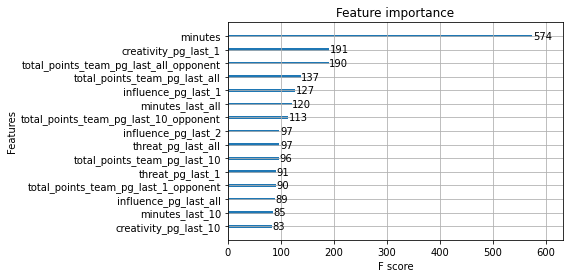

In [ ]:
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

# New Section

**Predictions**

---



In [ ]:
season = '2021'
cat_vars = ['season', 'position', 'was_home']
cont_vars = ['gw', 'minutes']
dep_var = ['total_points']

# find the latest gameweek
# last_gw = train_df['gw'][train_df['season'] == season].max()
last_gw = 8

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

9

In [ ]:
remaining_season_df = pd.read_csv('/content/drive/MyDrive/FPL(SolPaul)/fpl-prediction-master/data/remaining_season.csv', 
                                  index_col=0).sort_values(by=['gw', 'team'])

remaining_season_df['season'] = season
remaining_season_df['total_points'] = 0
remaining_season_df['kickoff_time'] = '9999-99-99'

# append remaining season to end of training set
train_df = train_df.append(remaining_season_df, sort=False).reset_index(drop=True)

In [ ]:
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points', 'ict_index', 'threat'], 
                                                    ['all', 1, 2, 3, 5, 10])

In [ ]:
# lag_train_df.drop(columns=['ict_index_last_all', 'ict_index'], inplace=True)
# lag_train_df.shape
# lag_train_df.head()

In [ ]:
player_lag_vars

['minutes_last_all',
 'minutes_last_1',
 'minutes_last_2',
 'minutes_last_3',
 'minutes_last_5',
 'minutes_last_10',
 'total_points_pg_last_all',
 'total_points_pg_last_1',
 'total_points_pg_last_2',
 'total_points_pg_last_3',
 'total_points_pg_last_5',
 'total_points_pg_last_10',
 'ict_index_pg_last_all',
 'ict_index_pg_last_1',
 'ict_index_pg_last_2',
 'ict_index_pg_last_3',
 'ict_index_pg_last_5',
 'ict_index_pg_last_10',
 'threat_pg_last_all',
 'threat_pg_last_1',
 'threat_pg_last_2',
 'threat_pg_last_3',
 'threat_pg_last_5',
 'threat_pg_last_10']

In [ ]:
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [ ]:
valid_season = '2021'
valid_gw = next_gw
valid_len = 38 - next_gw + 1

train_predict_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

In [ ]:
train_predict_df.shape

(113012, 45)

In [ ]:
X, y = train_predict_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_predict_df[dep_var].copy()

In [ ]:
X['position'] = X['position'].apply(str)

# need to transform season
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

In [ ]:
X.shape

(113012, 41)

In [ ]:
# split out training and prediction sets
X_train = X_df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X_df.iloc[valid_idx]
y_test = y.iloc[valid_idx]



In [ ]:
print('X shape{}  Y shape{}'.format(X_test.shape, y_test.shape))

X shape(18124, 44)  Y shape(18124, 1)


In [ ]:
print(valid_idx[0], valid_idx[-1] - valid_idx[0] + 1)

94888 18124


In [ ]:
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

X_train_1 = X_df
y_train_1 = y
test_fold = np.repeat([-1, 0], [valid_idx[0], valid_idx[-1] - valid_idx[0] + 1])
ps = PredefinedSplit(test_fold)

gbm = xgb.XGBRegressor(objective="reg:squarederror")
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                            param_distributions=params, 
                            scoring="neg_mean_squared_error", 
                            n_iter=25, 
                            cv=ps, 
                            verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train_1, y_train_1)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 12.8min finished


Best parameters found:  {'gamma': 0.49121098284207804, 'learning_rate': 0.0032901778656201338, 'max_depth': 4, 'n_estimators': 126, 'subsample': 0.6838300402258255}
Lowest RMSE found:  0.9416885159949351


In [ ]:
xg_reg = xgb.XGBRegressor(objective="reg:squarederror",
                          gamma=0.4, learning_rate=0.08, max_depth=7, n_estimators=126, subsample=0.72)

xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

In [ ]:
preds.shape

(18124,)

In [ ]:
# pred_df = train_predict_df.iloc[valid_idx]
# pred_df['predicted_points'] = preds

In [ ]:
remaining_season_df['predicted_points'] = preds

In [ ]:
preds.max()

11.6740885

In [ ]:
remaining_season_df[remaining_season_df['gw'] == next_gw].sort_values(by='predicted_points', ascending=False).head(50)
# new_pred_df = pred_df.loc[:, ['gw', 'opponent_team', 'player', 'team', 'predicted_points', 'was_home']]
# new_pred_df[new_pred_df['gw'] == next_gw].sort_values(by='predicted_points', ascending=False).head(50)

,gw,team,opponent_team,player,position,price,play_proba,short_name,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,total_points,kickoff_time,predicted_points
148,9,Fulham,Everton,Ola_Aina,2,4.5,1.00,Aina,True,0.490763,1.140365,2021,90.00,0,9999-99-99,8.332113
142,9,Fulham,Everton,Antonee_Robinson,2,4.4,1.00,Robinson,True,0.490763,1.140365,2021,90.00,0,9999-99-99,8.070582
84,9,Aston Villa,Brighton and Hove Albion,Ross_Barkley,3,6.0,1.00,Barkley,True,0.699520,0.517797,2021,90.00,0,9999-99-99,7.886055
9194,9,Everton,Fulham,Michael_Keane,2,5.1,1.00,Keane,False,1.140365,0.490763,2021,90.00,0,9999-99-99,7.654136
282,9,Sheffield United,West Ham United,Enda_Stevens,2,5.3,1.00,Stevens,True,0.394966,0.646012,2021,90.00,0,9999-99-99,7.636421
286,9,Sheffield United,West Ham United,George_Baldock,2,5.3,1.00,Baldock,True,0.394966,0.646012,2021,90.00,0,9999-99-99,7.620654
340,9,Wolverhampton Wanderers,Southampton,Raúl_Jiménez,4,8.4,1.00,Jiménez,True,0.870249,0.491548,2021,90.00,0,9999-99-99,7.579813
58,9,Aston Villa,Brighton and Hove Albion,Emiliano_Martínez,1,4.8,1.00,Martínez,True,0.699520,0.517797,2021,90.00,0,9999-99-99,7.384265
196,9,Liverpool,Leicester City,Andrew_Robertson,2,7.1,1.00,Robertson,True,2.422967,1.052196,2021,90.00,0,9999-99-99,7.313665
132,9,Fulham,Everton,Aleksandar_Mitrović,4,5.7,1.00,Mitrović,True,0.490763,1.140365,2021,90.00,0,9999-99-99,7.270976


Experimentation


In [ ]:
gw_len=[]
for i in range(next_gw, next_gw +5):
  gw_len.append(i)
next_5_gw = remaining_season_df[remaining_season_df['gw'].isin(gw_len)] 


In [ ]:
next_5_gw.loc[:,['player', 'short_name', 'team', 'price', 'play_proba', 'opponent_team', 'predicted_points']].groupby(['player', 'short_name', 'team', 'price', 'play_proba']).agg(lambda x: x.sum()).sort_values(by='predicted_points', ascending=False).head(50)

,,,,,opponent_team,predicted_points
player,short_name,team,price,play_proba,,
Ross_Barkley,Barkley,Aston Villa,6.0,1.00,Brighton and Hove AlbionWest Ham UnitedNewcast...,37.863686
Raheem_Sterling,Sterling,Manchester City,11.5,1.00,Tottenham HotspurBurnleyFulhamManchester Unite...,37.586914
Andrew_Robertson,Robertson,Liverpool,7.1,1.00,Leicester CityBrighton and Hove AlbionWolverha...,36.899651
Emiliano_Martínez,Martínez,Aston Villa,4.8,1.00,Brighton and Hove AlbionWest Ham UnitedNewcast...,35.333366
Wilfried_Zaha,Zaha,Crystal Palace,7.4,1.00,BurnleyNewcastle UnitedWest Bromwich AlbionTot...,35.075508
Benjamin_Chilwell,Chilwell,Chelsea,6.0,1.00,Newcastle UnitedTottenham HotspurLeedsEvertonW...,34.590542
Ederson_Santana de Moraes,Ederson,Manchester City,6.0,1.00,Tottenham HotspurBurnleyFulhamManchester Unite...,34.497856
Vladimir_Coufal,Coufal,West Ham United,4.5,1.00,Sheffield UnitedAston VillaManchester UnitedLe...,33.845169
Rúben Santos_Gato Alves Dias,Dias,Manchester City,5.5,1.00,Tottenham HotspurBurnleyFulhamManchester Unite...,33.685734


In [ ]:
|folder_201920 = "/content/drive/My Drive/Fantasy-Premier-League-master/data/2019-20"
cleanedPlayers = folder_201920 + "/cleaned_players.csv"

In [ ]:
cleanedPlayers

'/content/drive/My Drive/Fantasy-Premier-League-master/data/2019-20/cleaned_players.csv'

# New Section

In [ ]:
cleanedPlayersDF = pd.read_csv(cleanedPlayers)
cleanedPlayersDF.head()

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost
0,Shkodran,Mustafi,0,2,43,1205,17,45.5,277.2,155.0,2,242,47.9,4,0,2,0.4,51
1,Héctor,Bellerín,1,0,44,1156,18,76.9,187.8,103.0,4,204,37.0,4,0,2,1.0,52
2,Sead,Kolasinac,0,2,55,1694,26,182.5,269.6,81.0,1,331,53.0,4,0,4,0.5,52
3,Ainsley,Maitland-Niles,0,2,41,1382,22,182.0,301.8,58.0,3,244,53.6,3,1,4,2.2,45
4,Sokratis,Papastathopoulos,2,0,57,1696,25,36.8,436.2,110.0,5,305,58.5,4,0,6,1.3,48


In [ ]:
player = cleanedPlayersDF['first_name'] == "Sadio"
cleanedPlayersDF[player]

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost
306,Sadio,Mané,18,10,221,2745,28,826.6,1010.2,1239.0,27,689,307.7,12,0,3,19.7,121


In [ ]:
GW = folder_201920 + '/gws/gw1.csv'
GW_DF = pd.read_csv(GW)
GW_DF.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,1.1,9.0,2019-08-10T11:30:00Z,90,11,0,0,0,0,1,0,23399,5,0,0.0,0,0,0,0,50,True,0
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,0.2,2.0,2019-08-10T14:00:00Z,6,16,0,0,0,0,1,0,8105,0,3,0.0,1,0,0,0,50,True,0
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,0.0,0.0,2019-08-10T14:00:00Z,0,18,0,0,0,0,1,0,16261,3,0,0.0,0,0,0,0,50,False,0
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,1.0,9.8,2019-08-10T14:00:00Z,90,15,0,0,0,0,1,2,3091,1,1,0.0,2,0,0,0,45,True,0
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,4.9,30.4,2019-08-11T15:30:00Z,90,6,0,0,0,0,1,0,1879259,0,4,2.0,8,0,0,0,55,True,0


In [ ]:
GW_DF['playerID'] = GW_DF['name'].str.extract(r'(\d+$)')
print(GW_DF[GW_DF['name'] == 'Mohamed_Salah_191'])

                  name  assists  bonus  ...  was_home  yellow_cards  playerID
372  Mohamed_Salah_191        1      2  ...      True             0       191

[1 rows x 33 columns]


In [ ]:
teams = folder_201920 + '/teams.csv'
teamsDF = pd.read_csv(teams)

In [ ]:
teamsDF.head()

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
0,3,0,NaN,1,0,Arsenal,0,0,0,1,ARS,4,1170,1170,1200,1150,1240,1180,NaN,False,0
1,7,0,NaN,2,0,Aston Villa,0,0,0,2,AVL,2,980,970,1040,1000,1050,1020,NaN,False,0
2,91,0,NaN,3,0,Bournemouth,0,0,0,127,BOU,2,1030,990,1050,1000,1020,1020,NaN,False,0
3,36,0,NaN,4,0,Brighton,0,0,0,131,BHA,2,1100,1100,1030,1040,1010,1050,NaN,False,0
4,90,0,NaN,5,0,Burnley,0,0,0,43,BUR,3,1070,1130,1110,970,1180,1110,NaN,False,0


In [ ]:
teamsSortedDefAway = teamsDF.sort_values('strength_defence_away')
teamsSortedDefAway

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
12,4,0,NaN,13,0,Newcastle,0,0,0,23,NEW,3,1040,1030,990,980,1100,1090,NaN,False,0
13,45,0,NaN,14,0,Norwich,0,0,0,14,NOR,2,1040,1030,990,990,1020,980,NaN,False,0
3,36,0,NaN,4,0,Brighton,0,0,0,131,BHA,2,1100,1100,1030,1040,1010,1050,NaN,False,0
1,7,0,NaN,2,0,Aston Villa,0,0,0,2,AVL,2,980,970,1040,1000,1050,1020,NaN,False,0
6,31,0,NaN,7,0,Crystal Palace,0,0,0,6,CRY,3,1180,1080,1040,1040,1120,1130,NaN,False,0
2,91,0,NaN,3,0,Bournemouth,0,0,0,127,BOU,2,1030,990,1050,1000,1020,1020,NaN,False,0
15,20,0,NaN,16,0,Southampton,0,0,0,20,SOU,3,1050,1080,1080,1110,1040,1150,NaN,False,0
8,13,0,NaN,9,0,Leicester,0,0,0,26,LEI,3,1080,1150,1100,1210,1160,1210,NaN,False,0
4,90,0,NaN,5,0,Burnley,0,0,0,43,BUR,3,1070,1130,1110,970,1180,1110,NaN,False,0
14,49,0,NaN,15,0,Sheffield Utd,0,0,0,18,SHU,3,1180,1170,1110,1050,1200,1180,NaN,False,0


In [ ]:
filter_teams_DEF_Away = teamsSortedDefAway[teamsSortedDefAway['strength_defence_away'] <= 1150]
filter_teams_DEF_Away

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
12,4,0,NaN,13,0,Newcastle,0,0,0,23,NEW,3,1040,1030,990,980,1100,1090,NaN,False,0
13,45,0,NaN,14,0,Norwich,0,0,0,14,NOR,2,1040,1030,990,990,1020,980,NaN,False,0
3,36,0,NaN,4,0,Brighton,0,0,0,131,BHA,2,1100,1100,1030,1040,1010,1050,NaN,False,0
1,7,0,NaN,2,0,Aston Villa,0,0,0,2,AVL,2,980,970,1040,1000,1050,1020,NaN,False,0
6,31,0,NaN,7,0,Crystal Palace,0,0,0,6,CRY,3,1180,1080,1040,1040,1120,1130,NaN,False,0
2,91,0,NaN,3,0,Bournemouth,0,0,0,127,BOU,2,1030,990,1050,1000,1020,1020,NaN,False,0
15,20,0,NaN,16,0,Southampton,0,0,0,20,SOU,3,1050,1080,1080,1110,1040,1150,NaN,False,0
8,13,0,NaN,9,0,Leicester,0,0,0,26,LEI,3,1080,1150,1100,1210,1160,1210,NaN,False,0
4,90,0,NaN,5,0,Burnley,0,0,0,43,BUR,3,1070,1130,1110,970,1180,1110,NaN,False,0
14,49,0,NaN,15,0,Sheffield Utd,0,0,0,18,SHU,3,1180,1170,1110,1050,1200,1180,NaN,False,0


In [ ]:
filter_teams_DEF_Home = teamsDF[teamsDF['strength_defence_home'] <= 1130]
filter_teams_DEF_Home.sort_values('strength_defence_home')

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
4,90,0,NaN,5,0,Burnley,0,0,0,43,BUR,3,1070,1130,1110,970,1180,1110,NaN,False,0
12,4,0,NaN,13,0,Newcastle,0,0,0,23,NEW,3,1040,1030,990,980,1100,1090,NaN,False,0
13,45,0,NaN,14,0,Norwich,0,0,0,14,NOR,2,1040,1030,990,990,1020,980,NaN,False,0
1,7,0,NaN,2,0,Aston Villa,0,0,0,2,AVL,2,980,970,1040,1000,1050,1020,NaN,False,0
2,91,0,NaN,3,0,Bournemouth,0,0,0,127,BOU,2,1030,990,1050,1000,1020,1020,NaN,False,0
17,57,0,NaN,18,0,Watford,0,0,0,33,WAT,3,1120,1120,1150,1020,1140,1030,NaN,False,0
18,21,0,NaN,19,0,West Ham,0,0,0,25,WHU,2,1030,1000,1150,1030,1030,1040,NaN,False,0
3,36,0,NaN,4,0,Brighton,0,0,0,131,BHA,2,1100,1100,1030,1040,1010,1050,NaN,False,0
6,31,0,NaN,7,0,Crystal Palace,0,0,0,6,CRY,3,1180,1080,1040,1040,1120,1130,NaN,False,0
14,49,0,NaN,15,0,Sheffield Utd,0,0,0,18,SHU,3,1180,1170,1110,1050,1200,1180,NaN,False,0


In [ ]:
filter_teams_DEF_Away_Strong = teamsDF[teamsDF['strength_defence_home'] >= 1150].sort_values('strength_defence_home')
filter_teams_DEF_Away_Strong

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
0,3,0,NaN,1,0,Arsenal,0,0,0,1,ARS,4,1170,1170,1200,1150,1240,1180,NaN,False,0
7,11,0,NaN,8,0,Everton,0,0,0,7,EVE,3,1210,1100,1180,1170,1240,1100,NaN,False,0
11,1,0,NaN,12,0,Man Utd,0,0,0,12,MUN,4,1330,1260,1260,1180,1300,1220,NaN,False,0
16,6,0,NaN,17,0,Spurs,0,0,0,21,TOT,4,1130,1100,1140,1200,1240,1180,NaN,False,0
19,39,0,NaN,20,0,Wolves,0,0,0,38,WOL,4,1230,1180,1200,1200,1190,1230,NaN,False,0
8,13,0,NaN,9,0,Leicester,0,0,0,26,LEI,3,1080,1150,1100,1210,1160,1210,NaN,False,0
5,8,0,NaN,6,0,Chelsea,0,0,0,4,CHE,4,1240,1240,1250,1220,1230,1220,NaN,False,0
9,14,0,NaN,10,0,Liverpool,0,0,0,10,LIV,5,1320,1310,1330,1310,1350,1340,NaN,False,0
10,43,0,NaN,11,0,Man City,0,0,0,11,MCI,5,1270,1260,1320,1320,1340,1330,NaN,False,0


In [ ]:
filter_teams_DEF_Home_Strong = teamsDF[teamsDF['strength_defence_home'] >= 1150].sort_values('strength_defence_home')
filter_teams_DEF_Home_Strong

,code,draw,form,id,loss,name,played,points,position,pulse_id,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
0,3,0,NaN,1,0,Arsenal,0,0,0,1,ARS,4,1170,1170,1200,1150,1240,1180,NaN,False,0
7,11,0,NaN,8,0,Everton,0,0,0,7,EVE,3,1210,1100,1180,1170,1240,1100,NaN,False,0
11,1,0,NaN,12,0,Man Utd,0,0,0,12,MUN,4,1330,1260,1260,1180,1300,1220,NaN,False,0
16,6,0,NaN,17,0,Spurs,0,0,0,21,TOT,4,1130,1100,1140,1200,1240,1180,NaN,False,0
19,39,0,NaN,20,0,Wolves,0,0,0,38,WOL,4,1230,1180,1200,1200,1190,1230,NaN,False,0
8,13,0,NaN,9,0,Leicester,0,0,0,26,LEI,3,1080,1150,1100,1210,1160,1210,NaN,False,0
5,8,0,NaN,6,0,Chelsea,0,0,0,4,CHE,4,1240,1240,1250,1220,1230,1220,NaN,False,0
9,14,0,NaN,10,0,Liverpool,0,0,0,10,LIV,5,1320,1310,1330,1310,1350,1340,NaN,False,0
10,43,0,NaN,11,0,Man City,0,0,0,11,MCI,5,1270,1260,1320,1320,1340,1330,NaN,False,0


In [ ]:
### MO SALAH
playersFolder = folder_201920 + '/players/'
playerFolder = playersFolder + 'Mohamed_Salah_191/'
playerGW = playerFolder + 'gw.csv'
# playerHistory = playerFolder + 'history.csv'
playerGW_DF = pd.read_csv(playerGW)
# playerHistory_DF = pd.read_csv(playerHistory)
# playerGW_DF.head()
isMatch = (playerGW_DF['opponent_team'].isin(filter_teams_DEF_Away_Strong['id'].tolist()) & playerGW_DF['was_home'])
playerGW_DF[isMatch]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
2,0,3,43,0,16.6,191,24,1,2,15.5,71.2,2019-08-24T16:30:00Z,90,1,0,0,0,0,3,0,2444065,1,3,67.0,15,-351541,47097,398638,125,True,0
7,0,0,5,0,37.7,191,74,1,0,15.0,18.2,2019-10-05T14:00:00Z,90,9,0,0,0,0,8,0,2797360,1,2,94.0,2,-92287,34441,126728,125,True,0
9,0,0,25,0,15.3,191,94,1,1,15.3,45.0,2019-10-27T16:30:00Z,84,17,0,0,0,0,10,0,2096834,1,2,93.0,7,-114968,23153,138121,124,True,0
11,0,1,25,0,3.3,191,114,1,1,9.7,45.2,2019-11-10T16:30:00Z,86,11,0,0,0,0,12,0,1894445,1,3,48.0,8,-110997,26242,137239,123,True,0
14,0,0,0,0,0.0,191,149,0,0,0.0,0.0,2019-12-04T20:15:00Z,0,8,0,0,0,0,15,0,1585242,2,5,0.0,0,-49660,11978,61638,122,True,0
18,0,0,0,1,38.5,191,194,0,0,8.2,12.6,2019-12-29T16:30:00Z,90,20,0,0,0,0,20,0,1787526,0,1,31.0,3,63148,89337,26189,123,True,0
21,0,0,23,1,32.7,191,224,0,1,13.2,44.4,2020-01-19T16:30:00Z,90,12,0,0,0,0,23,0,1891529,0,2,55.0,7,48254,93684,45430,123,True,1
36,1,0,15,0,16.8,191,364,3,0,9.5,25.6,2020-07-22T19:15:00Z,78,6,0,0,0,0,46,0,2559844,3,5,53.0,5,-69649,24957,94606,125,True,0


In [ ]:
# MANE STATS
gw_Sadio = GW_DF[GW_DF['name'].str.contains('Sadio')]
gw_Sadio
sadioGW = playersFolder + 'Sadio_Mané_192/gw.csv'
sadioGW_DF = pd.read_csv(sadioGW)
# auba_team_filter = teamsSortedDefAway[teamsSortedDefAway['strength_defence_away'] <= 1080]
sadioFixture = (sadioGW_DF['opponent_team'].isin(filter_teams_DEF_Away['id'].tolist()) & sadioGW_DF['was_home'])
sadioGW_DF[sadioFixture]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,0,0,3,0,1.3,192,1,0,0,0.9,1.2,2019-08-09T19:00:00Z,16,14,0,0,0,0,1,0,842260,1,4,6.0,1,0,0,0,115,True,0
4,0,3,41,0,26.0,192,44,1,2,15.9,67.2,2019-09-14T11:30:00Z,90,13,0,0,0,0,5,0,1276973,1,3,66.0,15,39157,119917,80760,115,True,0
7,1,2,35,0,16.5,192,74,1,1,11.3,51.6,2019-10-05T14:00:00Z,90,9,0,0,0,0,8,0,1499465,1,2,45.0,12,25505,88004,62499,116,True,0
13,0,0,17,0,32.9,192,134,1,0,11.6,23.2,2019-11-30T15:00:00Z,90,4,0,0,0,0,14,0,2894269,1,2,60.0,2,128984,146886,17902,122,True,0
19,0,0,25,1,15.8,192,204,0,1,14.9,45.4,2020-01-02T20:00:00Z,77,15,0,0,0,0,21,0,2818918,0,2,88.0,8,84941,114078,29137,123,True,0
24,0,0,0,0,0.0,192,245,0,0,0.0,0.0,2020-02-01T15:00:00Z,0,16,0,0,0,0,25,0,1801221,0,4,0.0,0,-1245778,17452,1263230,123,True,0
28,1,3,39,0,28.6,192,286,1,1,12.5,56.2,2020-03-07T12:30:00Z,90,3,0,0,0,0,29,0,1792129,1,2,40.0,13,-15689,62841,78530,124,True,0
30,0,1,37,1,62.7,192,304,0,1,13.7,49.6,2020-06-24T19:15:00Z,83,7,0,0,0,0,40,0,1862270,0,4,25.0,9,29859,69642,39783,125,True,0
32,0,3,33,1,13.1,192,324,0,1,8.4,40.0,2020-07-05T15:30:00Z,90,2,0,0,0,0,42,0,1773073,0,2,31.0,11,-53937,19332,73269,124,True,0
34,0,0,19,0,58.8,192,344,1,0,13.0,21.6,2020-07-11T14:00:00Z,90,5,0,0,0,0,44,0,1686099,1,1,50.0,2,-71456,26000,97456,123,True,0


In [ ]:
folder_202021 = '/content/drive/My Drive/Fantasy-Premier-League-master/data/2020-21/'


In [ ]:
#Auba Stats
gw_Auba = GW_DF[GW_DF['name'].str.contains('Aubameyang')]
gw_Auba

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,playerID
418,Pierre-Emerick_Aubameyang_11,0,0,25,1,6.5,11,10,0,1,12.2,37.4,2019-08-11T13:00:00Z,90,13,0,0,0,0,1,0,1474313,1,0,78.0,6,0,0,0,110,False,0,11


In [ ]:
playerFolder = playersFolder + '/Pierre-Emerick_Aubameyang_11/'
aubaGW = playerFolder + 'gw.csv'
aubaGW_DF = pd.read_csv(aubaGW)
auba_team_filter = teamsSortedDefAway[teamsSortedDefAway['strength_defence_away'] <= 1080]
# aubaGW_DF[aubaGW_DF['opponent_team'].isin(filter_teams_DEF_Away['id'].tolist()) & aubaGW_DF['was_home'] == False] 1811963
aubaFixture = (aubaGW_DF['opponent_team'].isin(filter_teams_DEF_Away['id'].tolist()) & aubaGW_DF['was_home'])
aubaGW_DF[aubaFixture]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
1,0,1,25,0,18.9,11,11,1,1,9.4,42.2,2019-08-17T11:30:00Z,90,5,0,0,0,0,2,0,1793344,1,2,33.0,6,113772,181990,68218,110,True,1
3,0,3,35,0,26.6,11,31,2,1,12.7,47.8,2019-09-01T15:30:00Z,90,17,0,0,0,0,4,0,1499754,2,2,53.0,9,-109901,59121,169022,110,True,0
5,0,0,26,0,1.6,11,51,2,1,9.5,34.6,2019-09-22T15:30:00Z,90,2,0,0,0,0,6,0,1618723,2,3,59.0,5,117466,158891,41425,110,True,1
7,0,0,0,1,12.8,11,71,0,0,6.1,1.0,2019-10-06T13:00:00Z,90,3,0,0,0,0,8,0,1829633,0,1,47.0,2,201560,219717,18157,110,True,0
9,0,0,5,0,12.4,11,91,2,0,2.4,1.0,2019-10-27T16:30:00Z,90,7,0,0,0,0,10,0,2024573,2,2,11.0,2,52748,105976,53228,111,True,0
12,1,0,10,0,11.1,11,121,2,0,5.9,10.6,2019-11-23T15:00:00Z,90,16,0,0,0,0,13,0,1743921,2,2,37.0,5,-85518,75823,161341,110,True,0
14,0,0,10,0,21.3,11,141,2,0,5.3,7.2,2019-12-05T20:15:00Z,90,4,0,0,0,0,15,0,1701355,2,1,24.0,2,81531,101589,20058,109,True,0
22,0,0,0,0,0.0,11,221,0,0,0.0,0.0,2020-01-18T15:00:00Z,0,15,0,0,0,0,23,0,988382,1,1,0.0,0,-387490,5225,392715,107,True,0
25,0,2,42,1,8.2,11,251,0,1,10.1,42.8,2020-02-16T16:30:00Z,90,13,0,0,0,0,26,0,1240907,0,4,50.0,8,39982,76889,36907,108,True,0
27,0,0,12,1,35.9,11,281,0,0,5.6,8.4,2020-03-07T15:00:00Z,90,19,0,0,0,0,29,0,2137772,0,1,12.0,2,670947,681665,10718,111,True,0


In [ ]:
aubaGW_DF.selected

0     1474313
1     1793344
2     1573634
3     1499754
4     1468857
5     1618723
6     1587257
7     1829633
8     1970131
9     2024573
10    1860399
11    1811963
12    1743921
13    1605491
14    1701355
15    1560111
16    1385735
17    1403413
18    1324251
19    1298352
20    1289768
21    1381989
22     988382
23     935720
24    1206479
25    1240907
26    1345575
27    2137772
28    2209579
29    2209579
30    1897324
31    1886191
32    1803712
33    1749870
34    1711638
35    1617394
36    1663435
37    1759479
Name: selected, dtype: int64

In [ ]:
# Ings STATS
# gw_Ings = GW_DF[GW_DF['name'].str.contains('Ings')]
# gw_Ings
ingsFolder = playersFolder + '/Danny_Ings_313/'
ingsGW = ingsFolder + 'gw.csv'
ings_gw_df = pd.read_csv(ingsGW)
ings_gw_df
ings_team_filter = (ings_gw_df['opponent_team'].isin(filter_teams_DEF_Home_Strong['id'].tolist()) & ings_gw_df['was_home'])
# # aubaGW_DF[aubaGW_DF['opponent_team'].isin(filter_teams_DEF_Away['id'].tolist()) & aubaGW_DF['was_home'] == False] 1811963
# # aubaFixture = (aubaGW_DF['opponent_team'].isin(filter_teams_DEF_Home['id'].tolist()) & ~aubaGW_DF['was_home'])
ings_gw_df[ings_team_filter]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
1,0,1,22,0,0.8,313,19,1,1,8.9,29.2,2019-08-17T14:00:00Z,26,10,0,0,0,0,2,0,119615,2,1,59.0,6,-17541,3638,21179,60,True,0
3,0,0,9,0,14.8,313,39,1,0,5.0,11.2,2019-08-31T11:30:00Z,76,12,0,0,0,0,4,0,144458,1,1,24.0,2,3546,27796,24250,60,True,0
7,0,1,27,0,10.8,313,78,3,1,10.8,36.4,2019-10-06T13:00:00Z,80,6,0,0,0,0,8,0,110197,4,1,61.0,7,6341,13465,7124,59,True,0
9,0,0,0,0,1.8,313,98,5,0,0.8,5.0,2019-10-25T19:00:00Z,45,9,0,0,0,0,10,0,220367,9,0,1.0,1,94428,99856,5428,59,True,0
11,0,1,27,0,0.6,313,118,2,1,7.4,38.6,2019-11-09T15:00:00Z,90,8,0,0,0,0,12,0,190281,2,1,35.0,7,-11700,10180,21880,60,True,0
20,0,3,38,1,1.3,313,208,0,1,8.4,41.8,2020-01-01T15:00:00Z,75,17,0,0,0,0,21,0,1236950,0,1,41.0,9,62289,138583,76294,66,True,0
22,0,0,4,0,1.9,313,228,3,0,2.6,1.8,2020-01-18T15:00:00Z,90,20,0,0,0,0,23,0,2055116,3,2,22.0,2,495038,527509,32471,69,True,0
30,0,0,2,0,3.5,313,308,2,0,3.7,1.8,2020-06-25T17:00:00Z,90,1,0,0,0,0,40,0,1900338,2,0,32.0,2,142251,179226,36975,72,True,0
32,0,0,5,1,12.0,313,328,0,0,3.7,19.0,2020-07-05T18:00:00Z,90,11,0,0,0,0,42,0,2018826,0,1,6.0,2,94393,151695,57302,73,True,0


In [ ]:
### SON FILTER
gw_Son = GW_DF[GW_DF['name'].str.contains('Son')]
gw_Son
sonFolder = playersFolder + '/Heung-Min_Son_342/'
sonGW = sonFolder + 'gw.csv'
son_gw_df = pd.read_csv(sonGW)
# son_gw_df
son_team_filter = (son_gw_df['opponent_team'].isin(filter_teams_DEF_Home['id'].tolist()) & ~son_gw_df['was_home'])
son_gw_df[son_team_filter]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
6,1,0,12,0,34.8,342,69,1,0,10.2,30.6,2019-09-28T14:00:00Z,63,16,0,0,0,0,7,0,674811,1,2,37.0,5,186319,220264,33945,97,True,0
20,0,0,0,0,0.0,342,208,0,0,0.0,0.0,2020-01-01T15:00:00Z,0,16,0,0,0,0,21,0,400887,0,1,0.0,0,-93183,3863,97046,98,False,0


In [ ]:
gw_Willian = GW_DF[GW_DF['name'].str.contains('Willian')]
gw_Willian
WillianFolder = playersFolder + '/Willian_Borges Da Silva_113/'
WillianGW = WillianFolder + 'gw.csv'
Willian_gw_df = pd.read_csv(WillianGW)
# son_gw_df
Willian_team_filter = (Willian_gw_df['opponent_team'].isin(filter_teams_DEF_Away['id'].tolist()) & Willian_gw_df['was_home'])
Willian_gw_df[Willian_team_filter]

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
1,0,0,3,0,1.0,113,14,0,0,0.5,0.2,2019-08-18T15:30:00Z,19,9,0,0,0,0,2,0,40401,1,1,4.0,1,-9760,1924,11684,70,True,0
3,0,0,6,0,2.8,113,33,1,0,0.9,4.2,2019-08-31T14:00:00Z,30,15,0,0,0,0,4,0,45519,2,2,2.0,1,-490,6804,7294,70,True,0
6,0,2,30,1,14.2,113,63,0,1,13.5,47.4,2019-09-28T14:00:00Z,90,4,0,0,0,0,7,0,57467,0,2,73.0,10,6367,10965,4598,70,True,0
8,0,0,18,1,44.8,113,83,0,0,9.6,16.2,2019-10-19T14:00:00Z,90,13,0,0,0,0,9,0,130403,0,1,35.0,3,30934,39340,8406,70,True,0
11,1,2,26,1,56.3,113,112,0,0,12.1,31.6,2019-11-09T12:30:00Z,90,7,0,0,0,0,12,0,197607,0,2,33.0,7,13067,29294,16227,71,True,1
13,0,0,6,0,7.5,113,132,0,0,1.6,6.0,2019-11-30T15:00:00Z,27,19,0,0,0,0,14,0,219845,1,0,2.0,1,7995,25927,17932,71,True,0
14,0,0,20,0,42.2,113,147,1,0,11.6,21.0,2019-12-04T19:30:00Z,90,2,0,0,0,0,15,0,201483,1,2,53.0,2,-18488,7873,26361,71,True,0
16,0,0,15,1,47.7,113,163,0,0,10.7,14.8,2019-12-14T15:00:00Z,64,3,0,0,0,0,17,0,147366,1,0,44.0,3,-10625,8731,19356,70,True,0
18,0,0,7,0,32.9,113,183,2,0,4.3,7.8,2019-12-26T15:00:00Z,83,16,0,0,0,0,19,0,333152,2,0,2.0,2,183445,189632,6187,71,True,0
21,1,0,26,1,33.1,113,213,0,0,12.6,18.0,2020-01-11T15:00:00Z,90,5,0,0,0,0,22,0,472304,0,3,75.0,6,11898,78180,66282,72,True,0
